# Introduction to Keras

The goal of this notebook is to check that you have a good environment setup and to build a very simple shallow model.

You will:
* familiarize yourself with [Keras](http://www.keras.io)
* get up to speed with using IPython notebook for experiments and plotting


In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

Let's generate a simple "dummy" dataset that we will try to classify. Scikit-learn has a variety of useful functions for generating dataset of various kinds for experimentation.

In [22]:
from sklearn.datasets import make_blobs, make_circles
from keras.utils import np_utils

X, y = make_blobs(n_samples=1000,
                  centers=[[0.1, 0.1],[0.9, 0.9]],
                  cluster_std=0.3,
                  n_features=2)

y = np_utils.to_categorical(y)

print 'Vectors: \n', X[:10]
print 'Labels: \n', y[:10]

Vectors: 
[[-0.0071908  -0.04474886]
 [-0.11825929 -0.04570289]
 [ 1.23541418  0.62585209]
 [ 0.76107447  0.93030956]
 [ 1.22044849  0.6402553 ]
 [-0.36156753 -0.14751289]
 [-0.22591834  0.15432094]
 [-0.15583782 -0.17204601]
 [ 0.28911357  0.486279  ]
 [ 0.22872544  0.30771732]]
Labels: 
[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


Our dummy dataset consists of vectors in a 2-dimensional space and a class label that is either 0 or 1. We will represent the labels as **one-hot** vectors by using Keras's `to_categorical` helper function.

A one-hot vector is a binary vector where there is a 1 in the position corresponding to the class label and 0 elsewhere.

Inspect the data in a scatter plot.

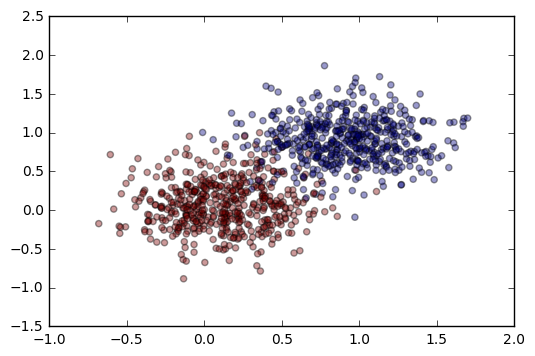

In [23]:
plt.scatter(X[:,0], X[:,1], c=y[:,0], alpha=0.4)

This is an "easy" dataset both because it is 2-dimensional and because it is **linearly separable**. This means we can draw a line to separate the two classes. Let's do that manually just for fun.

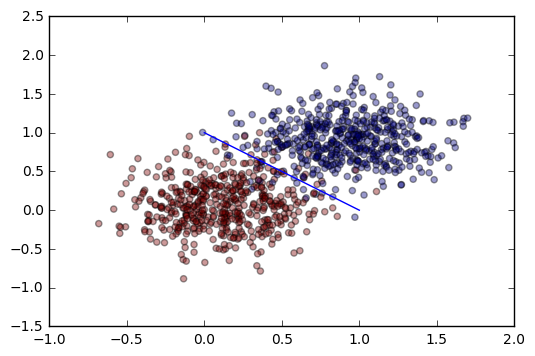

In [24]:
plt.scatter(X[:,0], X[:,1], c=y[:,0], alpha=0.4)
plt.plot([0, 1], [1, 0])

Now let's build a model to do this classification for us.

## Basics of modeling with Keras

[Keras](http://www.keras.io) is a simple neural net library. It helps you quickly define the structure of a network without having to write a lot of code.

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Keras gives you some flexible building blocks to build up your model. The `Sequence` model class is a simple container for a series of "layers" that process the input data in order. After creating a `Sequential` model...

In [26]:
model0 = Sequential()

... we can add layers to it one by one. For our first model we will use two layer types: `Dense` and `Activation`.

A [`Dense` layer](http://keras.io/layers/core/#dense) (also known as a **fully-connected** layer) consists of weights  and biases. An [`Activation` layer](http://keras.io/layers/core/#activation) applies a non-linear **activation function** on its input. We will make a "shallow" model for now: a fully-connected layer followed by a softmax activation.

In [27]:
model0.add(Dense(2, input_dim=2))
model0.add(Activation('softmax'))

The `Dense` constructor takes the output dimension as the first argument, in our case 2. Since this is the first layer in our model, we must also give it an `input_dim`, which is the dimension of our training data. Whenever we add more layers to our model, Keras knows what the input dimension will be by looking at the output dimension of the previous layer, so we can omit `input_dim` for later layers. The softmax activation doesn't ever change the dimension of the data, so it doesn't take an output dimension as an argument.

We can view the structure of the model with the handy `summary` method.

In [28]:
model0.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_3 (Dense)                  (None, 2)             6           dense_input_3[0][0]              
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 2)             0           dense_3[0][0]                    
Total params: 6
____________________________________________________________________________________________________


Keras models process multiple input examples at a time in a batch. A shape of `(None, 2)` tells us that the number of examples is not fixed (the first dimension) and each example has 2 dimensions.


- - -

## Ingredients for Deep Learning

For any application of deep learning, four things come together in the solution:

> complete model = data + structure + loss + optimizer

You, the modeler, must choose the ingredients that together solve your problem. We have seen what our data looks like and we have specified the strucure of our model. Now we will specify a [loss](http://keras.io/objectives/) ([**cross entropy**](https://en.wikipedia.org/wiki/Cross_entropy)) and an optimizer (regular **stochatic gradient descent**). We also tell Keras to keep track of the accuracy during training.


In [29]:
from keras.optimizers import SGD

model0.compile(loss='categorical_crossentropy',
               optimizer=SGD(lr=0.04),
               metrics=['accuracy'])

Let's generate a train/test split of our data. Our model learns from the **training** data, and we reserve **test** data for testing the performance of our model after it is trained.

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

Train the model:

In [31]:
model0.fit(X_train, y_train, nb_epoch=20, batch_size=16)

Epoch 1/20
750/750 [==============================] - 0s - loss: 0.4519 - acc: 0.7787      96/750 [==>...........................] - ETA: 0s - loss: 0.4999 - acc: 0.6250

Notice the signs of learning in the output. What are they?

Of course, we care much more about the accuracy of the model on the **test** data - this tells us that what the model learned on the training data **generalizes** to data the model never saw during training.

In [32]:
result = model0.evaluate(X_test, y_test)
print 'Test set loss: ', result[0]
print 'Test set accuracy: ', result[1]

 32/250 [==>...........................] - ETA: 0s224/250 [=========================>....] - ETA: 0sTest set loss:  0.15080025053
Test set accuracy:  0.963999997139


In general, we don't expect the model to do _better_ on the test set than the training set, but we hope that it does just as good.

## Decision Boundary

Since our example is in 2 dimensions only, we can iterate over a grid in the domain of the data and test each grid point to see how our model classifies it. Let's define a function to do this and plot the result.

In [33]:
def plot_decision_boundary(model, X, y):
    X_max = X.max(axis=0)
    X_min = X.min(axis=0)
    xticks = np.linspace(X_min[0], X_max[0], 100)
    yticks = np.linspace(X_min[1], X_max[1], 100)
    xx, yy = np.meshgrid(xticks, yticks)
    ZZ = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = ZZ[:,0] >= 0.5
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax = plt.gca()
    ax.contourf(xx, yy, Z, cmap=plt.cm.bwr, alpha=0.2)
    ax.scatter(X[:,0], X[:,1], c=y[:,0], alpha=0.4)

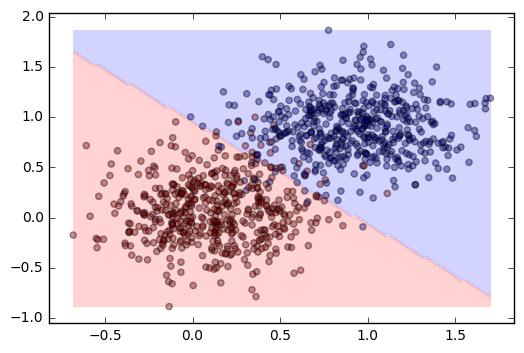

In [34]:
plot_decision_boundary(model0, X, y)

Congratulations! You trained your first model with Keras!

You don't need to understand the code in `plot_decision_boundary` in great detail, but you should understand what we are doing to create the plot: we are looking at each point on a grid that covers the input space, feeding it through the network to get the prediction, and coloring that point based on this prediction.

Why won't this approach for drawing the decision boundary work for more dimensions?

- - -
### Smaller model specification

Because it is so common to follow a full-connected layer with an activation function when building models, Keras allows you to specify the activation function when a `Dense` layer is created by using the keyword argument `activation`. Create the same model as we did above with this slightly more concise syntax. Refer to documentation for the `Dense` layer type [here](http://keras.io/layers/core/).
- - -

In [35]:
model1 = Sequential()
# Complete the model.
model1.add(Dense(2, activation='softmax', input_dim=2))

Compile and fit this smaller model. You should get very similar accuracy on the test data as we saw above.

In [36]:
# Compile, fit, and test the model.
model1.compile(loss='categorical_crossentropy',
               optimizer=SGD(lr=0.04),
               metrics=['accuracy'])
model1.fit(X_train, y_train, nb_epoch=20, batch_size=16)
result = model1.evaluate(X_test, y_test)
print 'Test set loss: ', result[0]
print 'Test set accuracy: ', result[1]

Epoch 1/20
750/750 [==============================] - 0s - loss: 0.5531 - acc: 0.7667      96/750 [==>...........................] - ETA: 0s - loss: 0.5725 - acc: 0.8125
Epoch 2/20
750/750 [====================

###  Non separable data

- Use the function `make_moons` to create 2 non separable sets.
- Split it into training and testing set
- Does your model still work?
- plot the decision boundary to further investigate what's going on



In [37]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000,
                  noise=0.1,
                  random_state=0)

y = np_utils.to_categorical(y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [39]:
# Compile, fit, and test the model.
model1.compile(loss='categorical_crossentropy',
               optimizer=SGD(lr=0.04),
               metrics=['accuracy'])
model1.fit(X_train, y_train, nb_epoch=20, batch_size=16)
result = model1.evaluate(X_test, y_test)
print 'Test set loss: ', result[0]
print 'Test set accuracy: ', result[1]

Epoch 1/20
750/750 [==============================] - 0s - loss: 1.0808 - acc: 0.4200      96/750 [==>...........................] - ETA: 0s - loss: 1.1977 - acc: 0.4062
Epoch 2/20
750/750 [====================

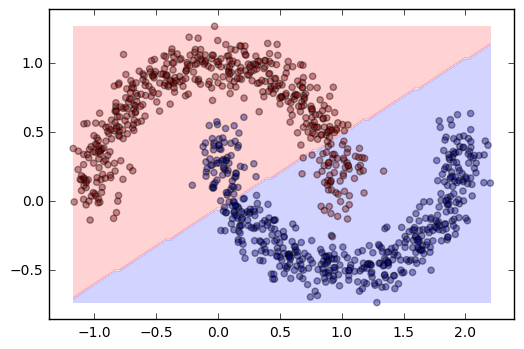

In [40]:
plot_decision_boundary(model1, X, y)